In [1]:
import os, sys
cur_dir = os.getcwd()
basename = os.path.basename(cur_dir)
for _ in range(5):
    if basename != 'OCLog':
        cur_dir = os.path.dirname(cur_dir)
        basename = os.path.basename(cur_dir)
        #print(cur_dir, basename)
    else:
        if cur_dir not in sys.path:
            sys.path.append(cur_dir)
            #print(sys.path)
import os
from openpyxl import Workbook
from openpyxl import load_workbook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import trange, tqdm, tnrange
from oclog.BGL.bglogUKC import BGLog, get_embedding_layer
from oclog.openset.boundary_loss import euclidean_metric, BoundaryLoss
from oclog.openset.pretraining import LogLineEncoder, LogSeqEncoder, LogClassifier
# from oclog.openset.openset import OpenSet
from oclog.openset.opensetv6 import OpenSet
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import sklearn.metrics as m
import warnings
warnings.filterwarnings('ignore')
def update_tracker(file_name, data):
    if os.path.exists(file_name):
        wb = load_workbook(file_name)
    else:
        wb = Workbook()    
    wb.save(file_name)
    # wb.close(file_name)
    orig_df = pd.read_excel(file_name,)
    #print(orig_df.head())
    new_df = pd.DataFrame(data, )
    concat_df = pd.concat([orig_df, new_df], axis=0)
    #print(concat_df.head())
    concat_df.to_excel(file_name)
    return concat_df

def oset_train(ablation=5000,designated_ukc_cls=3,num_classes=2,embedding_size=128,lr_rate=3,optimizer='sgd',
pretrain_epochs=3,octrain_epochs=200,wait_patience=3, debug=False, tracker='tracker.xlsx', comment='',
             tracker_update=True):
    tf.random.set_seed(1234)
    np.random.seed(1234) 
    bglog = BGLog(save_padded_num_sequences=False, debug=debug,  load_from_pkl=True, )
    train_test = bglog.get_tensor_train_val_test(ablation=ablation, designated_ukc_cls=designated_ukc_cls )
    train_data, val_data, test_data = train_test
    line_encoder = LogLineEncoder(bglog, chars_in_line=64)
    logSeqencer =  LogSeqEncoder(line_in_seq=32, dense_neurons=embedding_size)
    ptmodel = LogClassifier(line_encoder=line_encoder, seq_encoder=logSeqencer, num_classes=num_classes)
    ptmodel.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    hist = ptmodel.fit(train_data, validation_data=val_data, epochs=pretrain_epochs)    
    pre_tr_acc = hist.history.get('accuracy')[len(hist.history.get('accuracy'))-1]
    # print(round(pre_tr_acc, 4))
    pre_val_acc = hist.history.get('val_accuracy')[len(hist.history.get('val_accuracy'))-1]
    # print(round(pre_val_acc, 4))
    oset = OpenSet(num_classes, ptmodel, embedding_size=embedding_size)
    _, _ = oset.train(train_data,data_val=val_data, epochs=octrain_epochs, 
                      lr_rate=lr_rate, wait_patience=wait_patience, optimizer=optimizer,
                     pretrain_hist=hist)
    _, _, f1_weighted, f_measure = oset.evaluate(test_data, ukc_label=designated_ukc_cls)
    lst = list(tf.reshape(oset.radius, (1, num_classes)).numpy()[0])
    lst = [str(i) for i in lst]
    radius = ','.join(lst)    
    loss = oset.losses[len(oset.losses)-1].numpy()    
    tracker_data = {'ablation':[ablation],'designated_ukc_cls': [designated_ukc_cls],'num_classes': [num_classes],
                   'embedding_size': [embedding_size], 'lr_rate': [lr_rate], 'optimizer': [optimizer],
                    'pretrain_epochs': [pretrain_epochs],'octrain_epochs': [oset.epoch], 'wait_patience': [wait_patience], 
                   'f1_weighted': [f1_weighted], 'f1_macro': f_measure.get('F1-score'), 
                   'F1Known': f_measure.get('Known'), 'F1Open': f_measure.get('Open'), 'loss':[loss], 'Radius': radius,
                   'pre_tr_acc': pre_tr_acc, 'pre_val_acc': pre_val_acc,'comment': comment}
    
    if tracker_update:
        update_tracker(tracker, tracker_data)
    return test_data, oset, hist

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 2400
val_0:, 300
test_0:, 300
train_1:, 2400
val_1:, 300
test_1:, 300
train_2:, 2400
val_2:, 300
test_2:, 300
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/10
225/225 [==============================] - 23s 97ms/step - loss: 0.0422 - accuracy: 0.9857 - precision: 0.9933 - recall: 0.9749 - val_loss: 0.0029 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/10
225/225 [==============================] - 21s 95ms/step - loss: 0.0023 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9994 - val_loss: 0.0038 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/10
225/225 [==============================] - 21s 94ms/step - loss: 5.2741e-04 - accuracy: 0.9999 - precision: 0.9999 - recall: 0.9999 - val_loss: 0.0497 - val_accuracy: 0.9799 - val_pr

100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:28<00:00,  8.02it/s]


epoch: 1/200, train_loss: 7.153515815734863, F1_train: 0.6808977858129492 F1_val: 0.6890074211502782


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:28<00:00,  8.03it/s]


epoch: 2/200, train_loss: 7.153472900390625, F1_train: 0.699450319871884 F1_val: 0.6931595622119816


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:28<00:00,  7.99it/s]


epoch: 3/200, train_loss: 7.153521537780762, F1_train: 0.7066927224284855 F1_val: 0.692991214057508


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:29<00:00,  7.72it/s]


epoch: 4/200, train_loss: 7.15346622467041, F1_train: 0.7298765734563775 F1_val: 0.692991214057508


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:29<00:00,  7.56it/s]


epoch: 5/200, train_loss: 7.153414726257324, F1_train: 0.7359988020365378 F1_val: 0.6952156063389986


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:29<00:00,  7.70it/s]


epoch: 6/200, train_loss: 7.15341854095459, F1_train: 0.7392765386639238 F1_val: 0.6952156063389986


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:29<00:00,  7.74it/s]


epoch: 7/200, train_loss: 7.153411865234375, F1_train: 0.7431094411521186 F1_val: 0.692991214057508


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:29<00:00,  7.73it/s]


epoch: 8/200, train_loss: 7.1534857749938965, F1_train: 0.7447045774057043 F1_val: 0.6952156063389986


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:29<00:00,  7.70it/s]


epoch: 9/200, train_loss: 7.15336275100708, F1_train: 0.7470014140224647 F1_val: 0.6941034226190476


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:29<00:00,  7.71it/s]


epoch: 10/200, train_loss: 7.153407096862793, F1_train: 0.7490567621520823 F1_val: 0.692991214057508


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:29<00:00,  7.72it/s]


epoch: 11/200, train_loss: 7.1534743309021, F1_train: 0.7494808521989007 F1_val: 0.6952156063389986


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:29<00:00,  7.69it/s]


epoch: 12/200, train_loss: 7.153477668762207, F1_train: 0.7555958963962714 F1_val: 0.6983700333027102


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:29<00:00,  7.69it/s]


epoch: 13/200, train_loss: 7.153542518615723, F1_train: 0.756627496352432 F1_val: 0.6950352593266605


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:29<00:00,  7.69it/s]


epoch: 14/200, train_loss: 7.153546333312988, F1_train: 0.7573943016391231 F1_val: 0.6961468792788681


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:28<00:00,  7.83it/s]


epoch: 15/200, train_loss: 7.153475284576416, F1_train: 0.7584282655572321 F1_val: 0.6961468792788681


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:28<00:00,  7.84it/s]


epoch: 16/200, train_loss: 7.153563022613525, F1_train: 0.7590363922745624 F1_val: 0.6961468792788681


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:28<00:00,  7.83it/s]


epoch: 17/200, train_loss: 7.153493404388428, F1_train: 0.7592268389458046 F1_val: 0.6983700333027102


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:28<00:00,  7.84it/s]


epoch: 18/200, train_loss: 7.153552532196045, F1_train: 0.7594954862729405 F1_val: 0.6950352593266605


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:28<00:00,  7.84it/s]


epoch: 19/200, train_loss: 7.153536796569824, F1_train: 0.7596438250571222 F1_val: 0.6972584706959707


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:28<00:00,  7.84it/s]


epoch: 20/200, train_loss: 7.153427600860596, F1_train: 0.7600240622300589 F1_val: 0.6961468792788681


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:28<00:00,  7.78it/s]


epoch: 21/200, train_loss: 7.153528213500977, F1_train: 0.760362259200123 F1_val: 0.6972584706959707


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:28<00:00,  7.84it/s]


epoch: 22/200, train_loss: 7.153528213500977, F1_train: 0.7605520505150826 F1_val: 0.6961468792788681


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:29<00:00,  7.75it/s]


epoch: 23/200, train_loss: 7.153415203094482, F1_train: 0.7605520505150826 F1_val: 0.6972584706959707
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:28<00:00,  7.84it/s]


epoch: 24/200, train_loss: 7.153526306152344, F1_train: 0.7605520505150826 F1_val: 0.6972584706959707
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:28<00:00,  7.85it/s]


epoch: 25/200, train_loss: 7.153513431549072, F1_train: 0.7607417111647652 F1_val: 0.6972584706959707


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:28<00:00,  7.86it/s]


epoch: 26/200, train_loss: 7.153445720672607, F1_train: 0.7607417111647652 F1_val: 0.6972584706959707
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:28<00:00,  7.85it/s]


epoch: 27/200, train_loss: 7.1534929275512695, F1_train: 0.7607417111647652 F1_val: 0.6961468792788681
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:28<00:00,  7.84it/s]


epoch: 28/200, train_loss: 7.153504371643066, F1_train: 0.7607417111647652 F1_val: 0.6961468792788681
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:28<00:00,  7.82it/s]


epoch: 29/200, train_loss: 7.153543472290039, F1_train: 0.7607417111647652 F1_val: 0.6961468792788681
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:28<00:00,  7.83it/s]


epoch: 30/200, train_loss: 7.1534271240234375, F1_train: 0.7607417111647652 F1_val: 0.6972584706959707
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:28<00:00,  7.83it/s]


epoch: 31/200, train_loss: 7.153437614440918, F1_train: 0.7607417111647652 F1_val: 0.6961468792788681
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:28<00:00,  7.84it/s]


epoch: 32/200, train_loss: 7.153530120849609, F1_train: 0.7607417111647652 F1_val: 0.6972584706959707
train score not improving  going to wait state 7
val score not improving  going to wait state 7


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:28<00:00,  7.82it/s]


epoch: 33/200, train_loss: 7.153529167175293, F1_train: 0.7607417111647652 F1_val: 0.6972584706959707
train score not improving  going to wait state 8
val score not improving  going to wait state 8


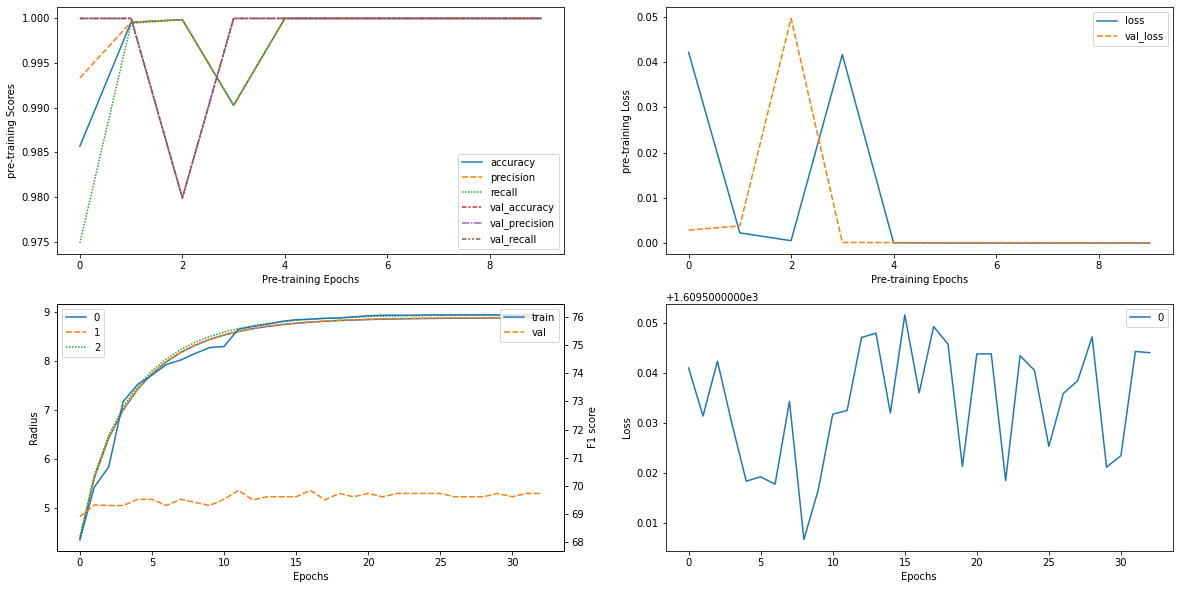

[[295   0   0   0]
 [  0 296   0   0]
 [  0   0   0 300]
 [  0   0   0 165]]
71.59
f1_weighted: 0.641504329004329, f1_macro: 0.6309523809523809, f1_micro: 0.715909090909091, f_measure: {'Known': 66.6667, 'Open': 52.381, 'F1-score': 63.0952}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       295
           1       1.00      1.00      1.00       296
           2       0.00      0.00      0.00       300
           5       0.35      1.00      0.52       165

    accuracy                           0.72      1056
   macro avg       0.59      0.75      0.63      1056
weighted avg       0.62      0.72      0.64      1056



In [2]:
comment="data 3000"
test_data, oset, hist = oset_train(ablation=3000,designated_ukc_cls=5,num_classes=3,embedding_size=12,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=10, wait_patience=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 2400
val_0:, 300
test_0:, 300
train_1:, 2400
val_1:, 300
test_1:, 300
train_2:, 2400
val_2:, 300
test_2:, 300
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/15
225/225 [==============================] - 23s 99ms/step - loss: 0.0422 - accuracy: 0.9857 - precision_1: 0.9933 - recall_1: 0.9749 - val_loss: 0.0029 - val_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 2/15
225/225 [==============================] - 22s 98ms/step - loss: 0.0023 - accuracy: 0.9996 - precision_1: 0.9996 - recall_1: 0.9994 - val_loss: 0.0038 - val_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 3/15
225/225 [==============================] - 22s 98ms/step - loss: 5.2741e-04 - accuracy: 0.9999 - precision_1: 0.9999 - recall_1: 0.9999 - val_loss: 0.0497 - val_accur

100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.29it/s]


epoch: 1/200, train_loss: 7.221926212310791, F1_train: 0.6798288422877657 F1_val: 0.6890074211502782


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.38it/s]


epoch: 2/200, train_loss: 7.221853733062744, F1_train: 0.6995207438887273 F1_val: 0.6942722780859917


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.27it/s]


epoch: 3/200, train_loss: 7.221993446350098, F1_train: 0.7057835282018687 F1_val: 0.692991214057508


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.38it/s]


epoch: 4/200, train_loss: 7.221989631652832, F1_train: 0.7231756185804349 F1_val: 0.6941034226190476


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.40it/s]


epoch: 5/200, train_loss: 7.221940994262695, F1_train: 0.7361743219097094 F1_val: 0.6941034226190476


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.38it/s]


epoch: 6/200, train_loss: 7.222003936767578, F1_train: 0.7388175055002927 F1_val: 0.6941034226190476


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.35it/s]


epoch: 7/200, train_loss: 7.222062587738037, F1_train: 0.7423098831579006 F1_val: 0.6963277649769585


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.46it/s]


epoch: 8/200, train_loss: 7.221983909606934, F1_train: 0.7443019236177073 F1_val: 0.692991214057508


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.46it/s]


epoch: 9/200, train_loss: 7.221923828125, F1_train: 0.7466285509021587 F1_val: 0.6952156063389986


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.46it/s]


epoch: 10/200, train_loss: 7.221938610076904, F1_train: 0.7493854018334349 F1_val: 0.6941034226190476


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.46it/s]


epoch: 11/200, train_loss: 7.221920013427734, F1_train: 0.7495254554100554 F1_val: 0.6952156063389986


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.46it/s]


epoch: 12/200, train_loss: 7.221915245056152, F1_train: 0.7557191443774685 F1_val: 0.6961468792788681


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.46it/s]


epoch: 13/200, train_loss: 7.222012042999268, F1_train: 0.7565234035279234 F1_val: 0.6972584706959707


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.44it/s]


epoch: 14/200, train_loss: 7.221955299377441, F1_train: 0.757674408829142 F1_val: 0.6972584706959707


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.41it/s]


epoch: 15/200, train_loss: 7.221968173980713, F1_train: 0.7580570163062725 F1_val: 0.6972584706959707


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.43it/s]


epoch: 16/200, train_loss: 7.222027778625488, F1_train: 0.7586299366531567 F1_val: 0.6972584706959707


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.44it/s]


epoch: 17/200, train_loss: 7.221977233886719, F1_train: 0.7588206464176873 F1_val: 0.6961468792788681


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.44it/s]


epoch: 18/200, train_loss: 7.222080230712891, F1_train: 0.7590112245674737 F1_val: 0.6961468792788681


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.44it/s]


epoch: 19/200, train_loss: 7.221978187561035, F1_train: 0.7593415491812233 F1_val: 0.6961468792788681


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.39it/s]


epoch: 20/200, train_loss: 7.221997261047363, F1_train: 0.7595318645099336 F1_val: 0.6972584706959707


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.14it/s]


epoch: 21/200, train_loss: 7.221901893615723, F1_train: 0.7595318645099336 F1_val: 0.6961468792788681
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.27it/s]


epoch: 22/200, train_loss: 7.221988201141357, F1_train: 0.7597220486319367 F1_val: 0.6972584706959707


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.39it/s]


epoch: 23/200, train_loss: 7.221976280212402, F1_train: 0.7597220486319367 F1_val: 0.6972584706959707
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.39it/s]


epoch: 24/200, train_loss: 7.221928119659424, F1_train: 0.7601020237981848 F1_val: 0.6950352593266605


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.40it/s]


epoch: 25/200, train_loss: 7.2219977378845215, F1_train: 0.7601719189205537 F1_val: 0.6950352593266605


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.40it/s]


epoch: 26/200, train_loss: 7.221960067749023, F1_train: 0.7603617102355134 F1_val: 0.6972584706959707


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.39it/s]


epoch: 27/200, train_loss: 7.222025394439697, F1_train: 0.7605513708851959 F1_val: 0.6950352593266605


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.40it/s]


epoch: 28/200, train_loss: 7.221957683563232, F1_train: 0.7605513708851959 F1_val: 0.6950352593266605
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.34it/s]


epoch: 29/200, train_loss: 7.222110271453857, F1_train: 0.7605513708851959 F1_val: 0.6950352593266605
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.41it/s]


epoch: 30/200, train_loss: 7.221968650817871, F1_train: 0.7605513708851959 F1_val: 0.6950352593266605
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.41it/s]


epoch: 31/200, train_loss: 7.221922874450684, F1_train: 0.7605513708851959 F1_val: 0.6961468792788681
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.41it/s]


epoch: 32/200, train_loss: 7.221977710723877, F1_train: 0.7605513708851959 F1_val: 0.6972584706959707
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.42it/s]


epoch: 33/200, train_loss: 7.221938610076904, F1_train: 0.7606298069792901 F1_val: 0.6961468792788681


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.41it/s]


epoch: 34/200, train_loss: 7.221997261047363, F1_train: 0.7606298069792901 F1_val: 0.6972584706959707
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.41it/s]


epoch: 35/200, train_loss: 7.221978187561035, F1_train: 0.7606298069792901 F1_val: 0.6952156063389986
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.41it/s]


epoch: 36/200, train_loss: 7.221967697143555, F1_train: 0.7606298069792901 F1_val: 0.6950352593266605
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.41it/s]


epoch: 37/200, train_loss: 7.221978187561035, F1_train: 0.7606298069792901 F1_val: 0.6983700333027102


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.41it/s]


epoch: 38/200, train_loss: 7.221978187561035, F1_train: 0.7606298069792901 F1_val: 0.6961468792788681
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.41it/s]


epoch: 39/200, train_loss: 7.222043037414551, F1_train: 0.7606298069792901 F1_val: 0.6972584706959707
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.40it/s]


epoch: 40/200, train_loss: 7.221952438354492, F1_train: 0.7606298069792901 F1_val: 0.6950352593266605
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.32it/s]


epoch: 41/200, train_loss: 7.221957683563232, F1_train: 0.7606298069792901 F1_val: 0.6983700333027102
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.20it/s]


epoch: 42/200, train_loss: 7.221981525421143, F1_train: 0.7606298069792901 F1_val: 0.6972584706959707
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.36it/s]


epoch: 43/200, train_loss: 7.221978187561035, F1_train: 0.7606298069792901 F1_val: 0.6961468792788681
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.31it/s]


epoch: 44/200, train_loss: 7.221994876861572, F1_train: 0.7606298069792901 F1_val: 0.6972584706959707
train score not improving  going to wait state 7
val score not improving  going to wait state 7


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.40it/s]


epoch: 45/200, train_loss: 7.221892356872559, F1_train: 0.7606298069792901 F1_val: 0.6972584706959707
train score not improving  going to wait state 8
val score not improving  going to wait state 8


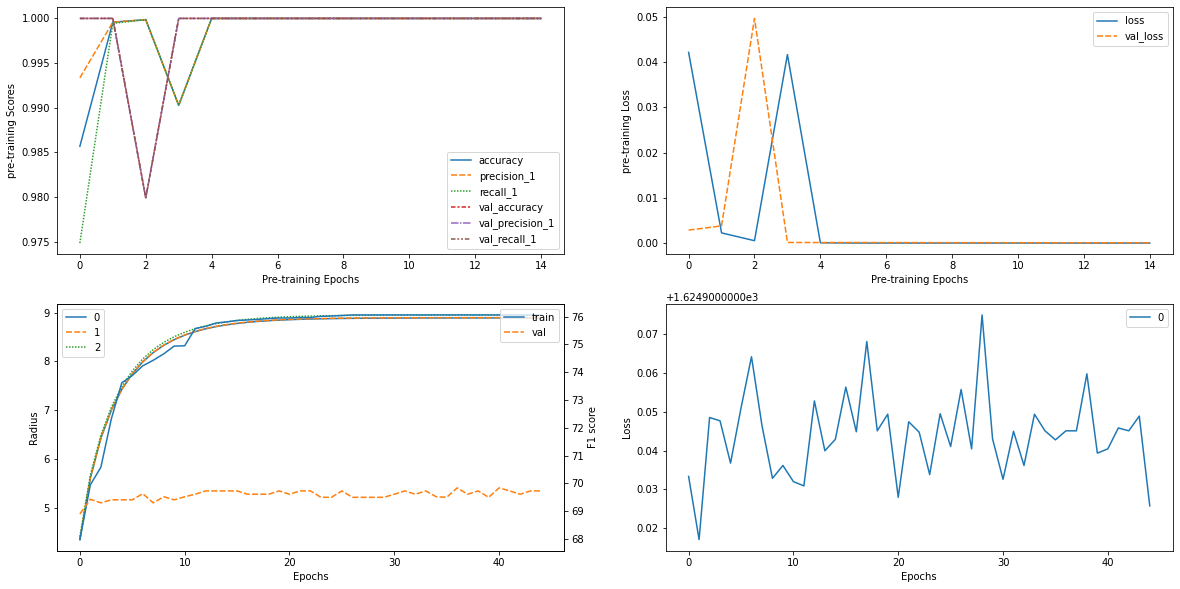

[[295   0   0   0]
 [  0 296   0   0]
 [  0   0   0 300]
 [  0   0   0 165]]
71.59
f1_weighted: 0.641504329004329, f1_macro: 0.6309523809523809, f1_micro: 0.715909090909091, f_measure: {'Known': 66.6667, 'Open': 52.381, 'F1-score': 63.0952}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       295
           1       1.00      1.00      1.00       296
           2       0.00      0.00      0.00       300
           5       0.35      1.00      0.52       165

    accuracy                           0.72      1056
   macro avg       0.59      0.75      0.63      1056
weighted avg       0.62      0.72      0.64      1056



In [4]:
comment="huge drop in score, lets increase the pretraining"
test_data, oset, hist = oset_train(ablation=3000,designated_ukc_cls=5,num_classes=3,embedding_size=12,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=15, wait_patience=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 2400
val_0:, 300
test_0:, 300
train_1:, 2400
val_1:, 300
test_1:, 300
train_2:, 2400
val_2:, 300
test_2:, 300
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/3
225/225 [==============================] - 23s 98ms/step - loss: 0.0422 - accuracy: 0.9857 - precision_2: 0.9933 - recall_2: 0.9749 - val_loss: 0.0029 - val_accuracy: 1.0000 - val_precision_2: 1.0000 - val_recall_2: 1.0000
Epoch 2/3
225/225 [==============================] - 22s 99ms/step - loss: 0.0023 - accuracy: 0.9996 - precision_2: 0.9996 - recall_2: 0.9994 - val_loss: 0.0038 - val_accuracy: 1.0000 - val_precision_2: 1.0000 - val_recall_2: 1.0000
Epoch 3/3
225/225 [==============================] - 22s 97ms/step - loss: 5.2741e-04 - accuracy: 0.9999 - precision_2: 0.9999 - recall_2: 0.9999 - val_loss: 0.0497 - val_accuracy

100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.24it/s]


epoch: 1/200, train_loss: 2.480018138885498, F1_train: 0.8954159153329849 F1_val: 0.988454433497537


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.24it/s]


epoch: 2/200, train_loss: 2.4798974990844727, F1_train: 0.925130829638087 F1_val: 0.9896446980854198


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.24it/s]


epoch: 3/200, train_loss: 2.480114698410034, F1_train: 0.9455484354991707 F1_val: 0.9931659735812133


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.25it/s]


epoch: 4/200, train_loss: 2.480092763900757, F1_train: 0.9502436064699579 F1_val: 0.9971862954709708


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.25it/s]


epoch: 5/200, train_loss: 2.480077028274536, F1_train: 0.9519113369467634 F1_val: 0.9971862954709708


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.24it/s]


epoch: 6/200, train_loss: 2.480055093765259, F1_train: 0.9528418422208033 F1_val: 0.99718637454982


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.24it/s]


epoch: 7/200, train_loss: 2.480020046234131, F1_train: 0.9587359141438487 F1_val: 0.9971862158569011


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.25it/s]


epoch: 8/200, train_loss: 2.4800045490264893, F1_train: 0.9600074154880139 F1_val: 0.9971862158569011


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.27it/s]


epoch: 9/200, train_loss: 2.4801266193389893, F1_train: 0.9610993003789344 F1_val: 0.9971862954709708


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.24it/s]


epoch: 10/200, train_loss: 2.4800922870635986, F1_train: 0.9618750307074907 F1_val: 0.9971862954709708


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.26it/s]


epoch: 11/200, train_loss: 2.480128288269043, F1_train: 0.9623742276270534 F1_val: 0.9971862158569011


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.25it/s]


epoch: 12/200, train_loss: 2.4800796508789062, F1_train: 0.9631449411139935 F1_val: 0.9971862158569011


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.08it/s]


epoch: 13/200, train_loss: 2.480203628540039, F1_train: 0.9638273331860905 F1_val: 0.9971862954709708


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.27it/s]


epoch: 14/200, train_loss: 2.480098247528076, F1_train: 0.9641675856055377 F1_val: 0.9971862954709708


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.35it/s]


epoch: 15/200, train_loss: 2.4800455570220947, F1_train: 0.9645072112648293 F1_val: 0.9971862158569011


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.35it/s]


epoch: 16/200, train_loss: 2.4799931049346924, F1_train: 0.964676789600349 F1_val: 0.9971862158569011


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.36it/s]


epoch: 17/200, train_loss: 2.480100393295288, F1_train: 0.9651000532274537 F1_val: 0.99718637454982


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.36it/s]


epoch: 18/200, train_loss: 2.4800665378570557, F1_train: 0.9656066869629277 F1_val: 0.99718637454982


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.35it/s]


epoch: 19/200, train_loss: 2.4801340103149414, F1_train: 0.9657752548648176 F1_val: 0.9971862158569011


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.35it/s]


epoch: 20/200, train_loss: 2.480055093765259, F1_train: 0.9661119269329669 F1_val: 0.9971862158569011


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.50it/s]


epoch: 21/200, train_loss: 2.480154037475586, F1_train: 0.9661959984934182 F1_val: 0.99718637454982


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.49it/s]


epoch: 22/200, train_loss: 2.480130672454834, F1_train: 0.9663640260520381 F1_val: 0.9971862158569011


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.49it/s]


epoch: 23/200, train_loss: 2.480154275894165, F1_train: 0.9664479821031442 F1_val: 0.9971862954709708


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.49it/s]


epoch: 24/200, train_loss: 2.4802165031433105, F1_train: 0.9666157788811105 F1_val: 0.99718637454982


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.48it/s]


epoch: 25/200, train_loss: 2.4801106452941895, F1_train: 0.9666996196607627 F1_val: 0.9971862158569011


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.48it/s]


epoch: 26/200, train_loss: 2.4801864624023438, F1_train: 0.9667834220693486 F1_val: 0.9977527239709444


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.48it/s]


epoch: 27/200, train_loss: 2.480013370513916, F1_train: 0.9667834220693486 F1_val: 0.99718637454982
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.49it/s]


epoch: 28/200, train_loss: 2.480149984359741, F1_train: 0.9668671861332041 F1_val: 0.9971862954709708


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.46it/s]


epoch: 29/200, train_loss: 2.4801204204559326, F1_train: 0.9668671861332041 F1_val: 0.9971862954709708
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.49it/s]


epoch: 30/200, train_loss: 2.4800591468811035, F1_train: 0.9668671861332041 F1_val: 0.9971862954709708
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.49it/s]


epoch: 31/200, train_loss: 2.4801032543182373, F1_train: 0.9668671861332041 F1_val: 0.9971861357021586
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.23it/s]


epoch: 32/200, train_loss: 2.4800772666931152, F1_train: 0.9668671861332041 F1_val: 0.99718637454982
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.38it/s]


epoch: 33/200, train_loss: 2.4801483154296875, F1_train: 0.9668671861332041 F1_val: 0.9971862158569011
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.39it/s]


epoch: 34/200, train_loss: 2.4801199436187744, F1_train: 0.9668671861332041 F1_val: 0.9971862954709708
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.31it/s]


epoch: 35/200, train_loss: 2.4802350997924805, F1_train: 0.9668671861332041 F1_val: 0.9971862158569011
train score not improving  going to wait state 7
val score not improving  going to wait state 7


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.36it/s]


epoch: 36/200, train_loss: 2.480104684829712, F1_train: 0.9668671861332041 F1_val: 0.9971862954709708
train score not improving  going to wait state 8
val score not improving  going to wait state 8


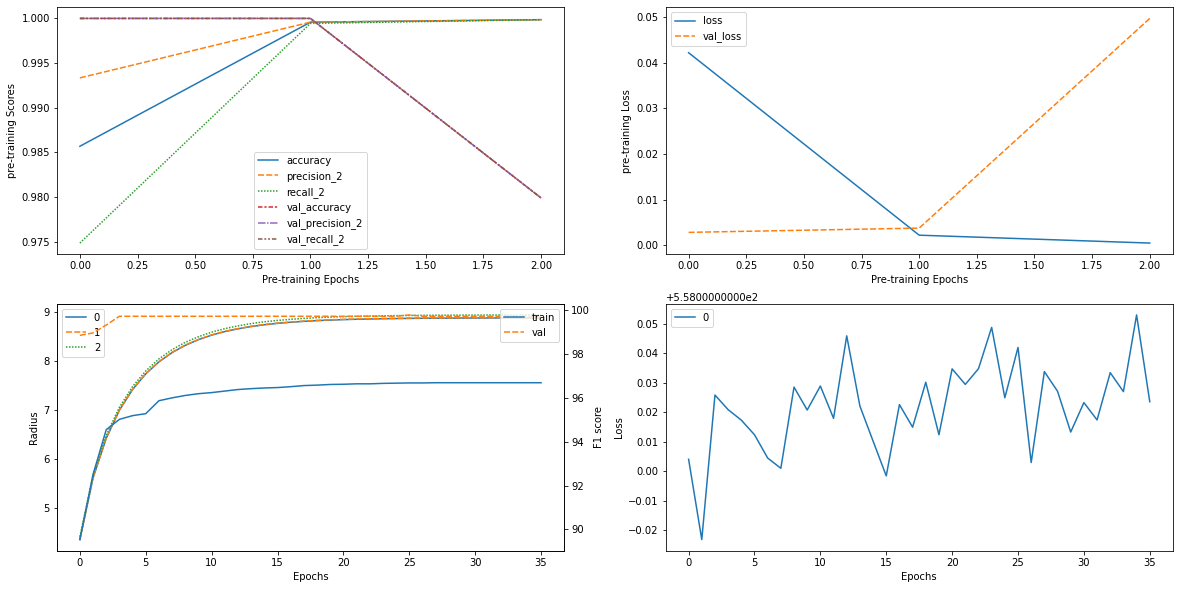

[[295   0   0   0]
 [  0 296   0   0]
 [  0   0 300   0]
 [ 70   3   0  92]]
93.09
f1_weighted: 0.9245757385958102, f1_macro: 0.9012126711314169, f1_micro: 0.9308712121212122, f_measure: {'Known': 96.2966, 'Open': 71.5953, 'F1-score': 90.1213}
              precision    recall  f1-score   support

           0       0.81      1.00      0.89       295
           1       0.99      1.00      0.99       296
           2       1.00      1.00      1.00       300
           5       1.00      0.56      0.72       165

    accuracy                           0.93      1056
   macro avg       0.95      0.89      0.90      1056
weighted avg       0.94      0.93      0.92      1056



In [5]:
comment="increasing pre-training not helping, lets decrease"
test_data, oset, hist = oset_train(ablation=3000,designated_ukc_cls=5,num_classes=3,embedding_size=12,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=3, wait_patience=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 2400
val_0:, 300
test_0:, 300
train_1:, 2400
val_1:, 300
test_1:, 300
train_2:, 2400
val_2:, 300
test_2:, 300
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/5
225/225 [==============================] - 24s 106ms/step - loss: 0.0422 - accuracy: 0.9857 - precision_3: 0.9933 - recall_3: 0.9749 - val_loss: 0.0029 - val_accuracy: 1.0000 - val_precision_3: 1.0000 - val_recall_3: 1.0000
Epoch 2/5
225/225 [==============================] - 23s 101ms/step - loss: 0.0023 - accuracy: 0.9996 - precision_3: 0.9996 - recall_3: 0.9994 - val_loss: 0.0038 - val_accuracy: 1.0000 - val_precision_3: 1.0000 - val_recall_3: 1.0000
Epoch 3/5
225/225 [==============================] - 23s 101ms/step - loss: 5.2741e-04 - accuracy: 0.9999 - precision_3: 0.9999 - recall_3: 0.9999 - val_loss: 0.0497 - val_accur

100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:33<00:00,  6.77it/s]


epoch: 1/200, train_loss: 7.0741472244262695, F1_train: 0.6848998373143438 F1_val: 0.687893695099399


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.24it/s]


epoch: 2/200, train_loss: 7.074374675750732, F1_train: 0.7002567204831552 F1_val: 0.6909340659340659


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.15it/s]


epoch: 3/200, train_loss: 7.074356555938721, F1_train: 0.70965022653933 F1_val: 0.6952156063389986


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.16it/s]


epoch: 4/200, train_loss: 7.074259281158447, F1_train: 0.7333765481205549 F1_val: 0.6952156063389986


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.07it/s]


epoch: 5/200, train_loss: 7.0742597579956055, F1_train: 0.7375484906567015 F1_val: 0.6941034226190476


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.10it/s]


epoch: 6/200, train_loss: 7.074288368225098, F1_train: 0.740560680630857 F1_val: 0.6941034226190476


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.06it/s]


epoch: 7/200, train_loss: 7.074212551116943, F1_train: 0.7442321734724544 F1_val: 0.6952156063389986


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.19it/s]


epoch: 8/200, train_loss: 7.074357986450195, F1_train: 0.7461746894852076 F1_val: 0.6952156063389986


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.20it/s]


epoch: 9/200, train_loss: 7.074336051940918, F1_train: 0.748027191406671 F1_val: 0.6941034226190476


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.14it/s]


epoch: 10/200, train_loss: 7.07433557510376, F1_train: 0.749633027917109 F1_val: 0.6941034226190476


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.19it/s]


epoch: 11/200, train_loss: 7.074364185333252, F1_train: 0.7510364104512642 F1_val: 0.6952156063389986


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.13it/s]


epoch: 12/200, train_loss: 7.0744404792785645, F1_train: 0.7578701287449391 F1_val: 0.6972584706959707


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.22it/s]


epoch: 13/200, train_loss: 7.074324607849121, F1_train: 0.7589381719735487 F1_val: 0.6950352593266605


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.15it/s]


epoch: 14/200, train_loss: 7.074279308319092, F1_train: 0.7592851859746295 F1_val: 0.6950352593266605


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.18it/s]


epoch: 15/200, train_loss: 7.074300289154053, F1_train: 0.7601234339237561 F1_val: 0.6972584706959707


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.08it/s]


epoch: 16/200, train_loss: 7.074306964874268, F1_train: 0.7608485152425932 F1_val: 0.6972584706959707


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.29it/s]


epoch: 17/200, train_loss: 7.074253082275391, F1_train: 0.7609267087688337 F1_val: 0.6950352593266605


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.12it/s]


epoch: 18/200, train_loss: 7.07436466217041, F1_train: 0.7611941371968606 F1_val: 0.6972584706959707


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.28it/s]


epoch: 19/200, train_loss: 7.074300289154053, F1_train: 0.7611941371968606 F1_val: 0.6961468792788681
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.27it/s]


epoch: 20/200, train_loss: 7.074333190917969, F1_train: 0.7615722858754673 F1_val: 0.6950352593266605


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.19it/s]


epoch: 21/200, train_loss: 7.074385643005371, F1_train: 0.7617611653597319 F1_val: 0.6972584706959707


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.20it/s]


epoch: 22/200, train_loss: 7.074334621429443, F1_train: 0.7617611653597319 F1_val: 0.6983700333027102


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.22it/s]


epoch: 23/200, train_loss: 7.074460029602051, F1_train: 0.7617611653597319 F1_val: 0.6950352593266605
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.08it/s]


epoch: 24/200, train_loss: 7.074336051940918, F1_train: 0.7618392897875313 F1_val: 0.6961468792788681


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.19it/s]


epoch: 25/200, train_loss: 7.074402332305908, F1_train: 0.7619954351213624 F1_val: 0.6961468792788681


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.16it/s]


epoch: 26/200, train_loss: 7.074256420135498, F1_train: 0.7621841848807064 F1_val: 0.6961468792788681


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.26it/s]


epoch: 27/200, train_loss: 7.074356555938721, F1_train: 0.7621841848807064 F1_val: 0.6983700333027102
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.20it/s]


epoch: 28/200, train_loss: 7.074340343475342, F1_train: 0.7623728050487292 F1_val: 0.6950352593266605


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.29it/s]


epoch: 29/200, train_loss: 7.074288368225098, F1_train: 0.7623728050487292 F1_val: 0.6972584706959707
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.31it/s]


epoch: 30/200, train_loss: 7.074343681335449, F1_train: 0.7623728050487292 F1_val: 0.6961468792788681
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.31it/s]


epoch: 31/200, train_loss: 7.074341773986816, F1_train: 0.7623728050487292 F1_val: 0.6972584706959707
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.32it/s]


epoch: 32/200, train_loss: 7.0743608474731445, F1_train: 0.7623728050487292 F1_val: 0.6961468792788681
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.32it/s]


epoch: 33/200, train_loss: 7.074306011199951, F1_train: 0.7623728050487292 F1_val: 0.6972584706959707
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.10it/s]


epoch: 34/200, train_loss: 7.074465274810791, F1_train: 0.7623728050487292 F1_val: 0.6972584706959707
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.30it/s]


epoch: 35/200, train_loss: 7.074315547943115, F1_train: 0.7623728050487292 F1_val: 0.6972584706959707
train score not improving  going to wait state 7
val score not improving  going to wait state 7


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.32it/s]


epoch: 36/200, train_loss: 7.074292182922363, F1_train: 0.7623728050487292 F1_val: 0.6972584706959707
train score not improving  going to wait state 8
val score not improving  going to wait state 8


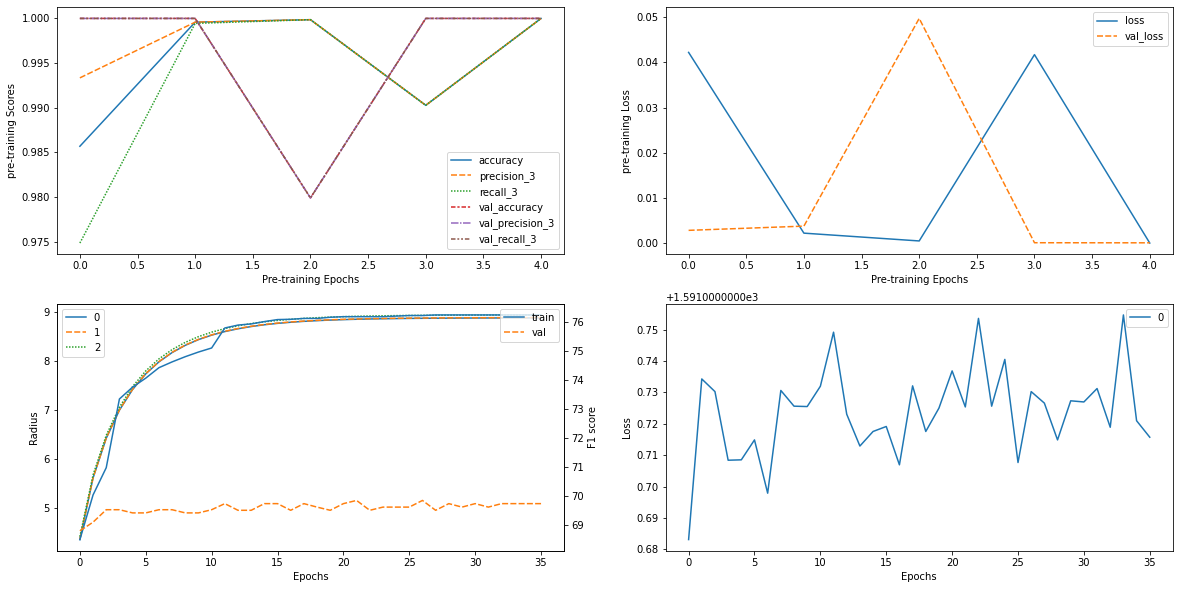

[[295   0   0   0]
 [  0 296   0   0]
 [  0   0   0 300]
 [  0   0   0 165]]
71.59
f1_weighted: 0.641504329004329, f1_macro: 0.6309523809523809, f1_micro: 0.715909090909091, f_measure: {'Known': 66.6667, 'Open': 52.381, 'F1-score': 63.0952}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       295
           1       1.00      1.00      1.00       296
           2       0.00      0.00      0.00       300
           5       0.35      1.00      0.52       165

    accuracy                           0.72      1056
   macro avg       0.59      0.75      0.63      1056
weighted avg       0.62      0.72      0.64      1056



In [6]:
comment="increasing pretraining a bit more"
test_data, oset, hist = oset_train(ablation=3000,designated_ukc_cls=5,num_classes=3,embedding_size=12,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=5, wait_patience=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 2400
val_0:, 300
test_0:, 300
train_1:, 2400
val_1:, 300
test_1:, 300
train_2:, 2400
val_2:, 300
test_2:, 300
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/5
225/225 [==============================] - 24s 104ms/step - loss: 0.0629 - accuracy: 0.9790 - precision_4: 0.9918 - recall_4: 0.9615 - val_loss: 1.8370e-04 - val_accuracy: 1.0000 - val_precision_4: 1.0000 - val_recall_4: 1.0000
Epoch 2/5
225/225 [==============================] - 22s 99ms/step - loss: 0.0015 - accuracy: 0.9997 - precision_4: 0.9997 - recall_4: 0.9997 - val_loss: 1.0675e-04 - val_accuracy: 1.0000 - val_precision_4: 1.0000 - val_recall_4: 1.0000
Epoch 3/5
225/225 [==============================] - 22s 96ms/step - loss: 8.9749e-05 - accuracy: 1.0000 - precision_4: 1.0000 - recall_4: 1.0000 - val_loss: 4.9489e-05 -

100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:32<00:00,  6.93it/s]


epoch: 1/200, train_loss: 3.86236834526062, F1_train: 0.6277503732731807 F1_val: 0.6547477446861097


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:32<00:00,  6.89it/s]


epoch: 2/200, train_loss: 3.8625590801239014, F1_train: 0.6475563939519439 F1_val: 0.6558651477832512


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.07it/s]


epoch: 3/200, train_loss: 3.862534284591675, F1_train: 0.9381290263043259 F1_val: 0.9890481864322852


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.06it/s]


epoch: 4/200, train_loss: 3.8625082969665527, F1_train: 0.9429039196902974 F1_val: 0.9890481864322852


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.08it/s]


epoch: 5/200, train_loss: 3.8625218868255615, F1_train: 0.9445324390846327 F1_val: 0.9896436268472907


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.08it/s]


epoch: 6/200, train_loss: 3.8624589443206787, F1_train: 0.9448386979408789 F1_val: 0.9896436268472907


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.10it/s]


epoch: 7/200, train_loss: 3.8624508380889893, F1_train: 0.9453079633795819 F1_val: 0.9902348568961263


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:32<00:00,  6.83it/s]


epoch: 8/200, train_loss: 3.862600088119507, F1_train: 0.9454000423336018 F1_val: 0.9896425481957489


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.07it/s]


epoch: 9/200, train_loss: 3.8625314235687256, F1_train: 0.9455423495416888 F1_val: 0.9896436268472907


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.05it/s]


epoch: 10/200, train_loss: 3.8625900745391846, F1_train: 0.945726374993789 F1_val: 0.990235815711827


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.09it/s]


epoch: 11/200, train_loss: 3.8625404834747314, F1_train: 0.945726374993789 F1_val: 0.9896425481957489
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.09it/s]


epoch: 12/200, train_loss: 3.862657070159912, F1_train: 0.945868562237949 F1_val: 0.9896425481957489


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.07it/s]


epoch: 13/200, train_loss: 3.8625271320343018, F1_train: 0.945868562237949 F1_val: 0.9896446980854198
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.06it/s]


epoch: 14/200, train_loss: 3.8624870777130127, F1_train: 0.945868562237949 F1_val: 0.9896446980854198
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:32<00:00,  7.00it/s]


epoch: 15/200, train_loss: 3.862443685531616, F1_train: 0.945868562237949 F1_val: 0.9896425481957489
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.07it/s]


epoch: 16/200, train_loss: 3.862541437149048, F1_train: 0.945868562237949 F1_val: 0.9896425481957489
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.07it/s]


epoch: 17/200, train_loss: 3.8625333309173584, F1_train: 0.945868562237949 F1_val: 0.9896446980854198
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.07it/s]


epoch: 18/200, train_loss: 3.8625783920288086, F1_train: 0.945868562237949 F1_val: 0.9896425481957489
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.06it/s]


epoch: 19/200, train_loss: 3.8625314235687256, F1_train: 0.945868562237949 F1_val: 0.9896436268472907
train score not improving  going to wait state 7
val score not improving  going to wait state 7


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:32<00:00,  6.87it/s]


epoch: 20/200, train_loss: 3.8626389503479004, F1_train: 0.9459605087995269 F1_val: 0.9896446980854198


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.06it/s]


epoch: 21/200, train_loss: 3.8625648021698, F1_train: 0.9459605087995269 F1_val: 0.9896425481957489
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.08it/s]


epoch: 22/200, train_loss: 3.8625922203063965, F1_train: 0.9459605087995269 F1_val: 0.9902338914335231
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.07it/s]


epoch: 23/200, train_loss: 3.8626439571380615, F1_train: 0.9459605087995269 F1_val: 0.9896446980854198
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.10it/s]


epoch: 24/200, train_loss: 3.862549304962158, F1_train: 0.9460315574825285 F1_val: 0.9896436268472907


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.07it/s]


epoch: 25/200, train_loss: 3.8626370429992676, F1_train: 0.9460315574825285 F1_val: 0.9896436268472907
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.17it/s]


epoch: 26/200, train_loss: 3.862476348876953, F1_train: 0.9460315574825285 F1_val: 0.9896436268472907
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.20it/s]


epoch: 27/200, train_loss: 3.8625802993774414, F1_train: 0.9460315574825285 F1_val: 0.9896414620535714
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:33<00:00,  6.74it/s]


epoch: 28/200, train_loss: 3.86255145072937, F1_train: 0.9460315574825285 F1_val: 0.9896446980854198
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.10it/s]


epoch: 29/200, train_loss: 3.86251163482666, F1_train: 0.9460315574825285 F1_val: 0.9896425481957489
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:32<00:00,  6.88it/s]


epoch: 30/200, train_loss: 3.862539768218994, F1_train: 0.9460315574825285 F1_val: 0.9896436268472907
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.24it/s]


epoch: 31/200, train_loss: 3.8625640869140625, F1_train: 0.9460315574825285 F1_val: 0.9896425481957489
train score not improving  going to wait state 7
val score not improving  going to wait state 7


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.28it/s]


epoch: 32/200, train_loss: 3.8626174926757812, F1_train: 0.9460315574825285 F1_val: 0.9896436268472907
train score not improving  going to wait state 8
val score not improving  going to wait state 8


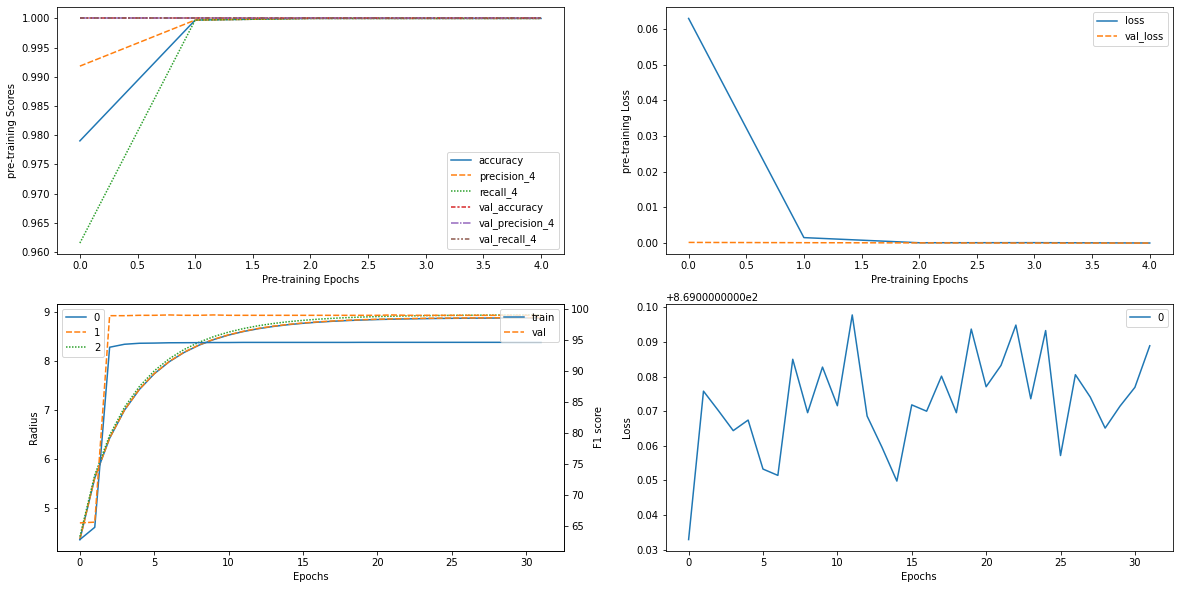

[[295   0   0   0]
 [  0 296   0   0]
 [  0   0 300   0]
 [ 15   0   0 150]]
98.58
f1_weighted: 0.9856333404887123, f1_macro: 0.9818968909878001, f1_micro: 0.9857954545454546, f_measure: {'Known': 99.1736, 'Open': 95.2381, 'F1-score': 98.1897}
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       295
           1       1.00      1.00      1.00       296
           2       1.00      1.00      1.00       300
           5       1.00      0.91      0.95       165

    accuracy                           0.99      1056
   macro avg       0.99      0.98      0.98      1056
weighted avg       0.99      0.99      0.99      1056



In [7]:
comment="training not increasing indicates learning probelm, lets increase em size"
test_data, oset, hist = oset_train(ablation=3000,designated_ukc_cls=5,num_classes=3,embedding_size=14,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=5, wait_patience=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 2400
val_0:, 300
test_0:, 300
train_1:, 2400
val_1:, 300
test_1:, 300
train_2:, 2400
val_2:, 300
test_2:, 300
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/5
225/225 [==============================] - 23s 97ms/step - loss: 0.0543 - accuracy: 0.9833 - precision_5: 0.9927 - recall_5: 0.9696 - val_loss: 8.0869e-05 - val_accuracy: 1.0000 - val_precision_5: 1.0000 - val_recall_5: 1.0000
Epoch 2/5
225/225 [==============================] - 22s 96ms/step - loss: 0.0076 - accuracy: 0.9974 - precision_5: 0.9974 - recall_5: 0.9974 - val_loss: 0.0245 - val_accuracy: 0.9944 - val_precision_5: 0.9944 - val_recall_5: 0.9944
Epoch 3/5
225/225 [==============================] - 22s 97ms/step - loss: 0.0070 - accuracy: 0.9989 - precision_5: 0.9989 - recall_5: 0.9989 - val_loss: 0.0360 - val_accuracy

100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.21it/s]


epoch: 1/200, train_loss: 5.4593353271484375, F1_train: 0.5618540357148404 F1_val: 0.6449184989832232


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.22it/s]


epoch: 2/200, train_loss: 5.4593915939331055, F1_train: 0.5814696530524204 F1_val: 0.6466695638432364


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.21it/s]


epoch: 3/200, train_loss: 5.459385871887207, F1_train: 0.5910705009599226 F1_val: 0.6466609371021137


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.03it/s]


epoch: 4/200, train_loss: 5.459319114685059, F1_train: 0.5975324229528849 F1_val: 0.6455448656735422


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.30it/s]


epoch: 5/200, train_loss: 5.459319114685059, F1_train: 0.6039883886746215 F1_val: 0.6472937246707193


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.30it/s]


epoch: 6/200, train_loss: 5.459341049194336, F1_train: 0.8862250048236358 F1_val: 0.9805092446270544


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.25it/s]


epoch: 7/200, train_loss: 5.459351062774658, F1_train: 0.8890016684245039 F1_val: 0.98112968591692


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.20it/s]


epoch: 8/200, train_loss: 5.459354400634766, F1_train: 0.891939502789622 F1_val: 0.9805054237503172


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.23it/s]


epoch: 9/200, train_loss: 5.459359169006348, F1_train: 0.8939060582366528 F1_val: 0.9811332660272589


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.24it/s]


epoch: 10/200, train_loss: 5.4593024253845215, F1_train: 0.8952069114431008 F1_val: 0.9823747170523138


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.25it/s]


epoch: 11/200, train_loss: 5.459372520446777, F1_train: 0.8962239542575724 F1_val: 0.9829892605190224


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.17it/s]


epoch: 12/200, train_loss: 5.459393501281738, F1_train: 0.8968693593947776 F1_val: 0.9829892605190224


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.23it/s]


epoch: 13/200, train_loss: 5.459361553192139, F1_train: 0.8973282119628091 F1_val: 0.9829950587940957


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.26it/s]


epoch: 14/200, train_loss: 5.45930814743042, F1_train: 0.8979687635692497 F1_val: 0.9829950587940957


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.16it/s]


epoch: 15/200, train_loss: 5.459355354309082, F1_train: 0.9005096841595259 F1_val: 0.9836047535211269


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.17it/s]


epoch: 16/200, train_loss: 5.459348201751709, F1_train: 0.9006898867128272 F1_val: 0.9836047535211269


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:35<00:00,  6.35it/s]


epoch: 17/200, train_loss: 5.459319114685059, F1_train: 0.9011396458106106 F1_val: 0.9836101398601398


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:34<00:00,  6.57it/s]


epoch: 18/200, train_loss: 5.459382057189941, F1_train: 0.9019465321371372 F1_val: 0.9836047535211269


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:41<00:00,  5.43it/s]


epoch: 19/200, train_loss: 5.459362506866455, F1_train: 0.9021253740341377 F1_val: 0.9836074561403508


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.25it/s]


epoch: 20/200, train_loss: 5.459411144256592, F1_train: 0.902214731593497 F1_val: 0.9836101398601398


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.29it/s]


epoch: 21/200, train_loss: 5.459364891052246, F1_train: 0.9040815334995905 F1_val: 0.9842180831031886


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:32<00:00,  6.93it/s]


epoch: 22/200, train_loss: 5.459383487701416, F1_train: 0.9042583631267314 F1_val: 0.984826930331992


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.09it/s]


epoch: 23/200, train_loss: 5.459368705749512, F1_train: 0.9044350265996537 F1_val: 0.9842230740463724


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:33<00:00,  6.72it/s]


epoch: 24/200, train_loss: 5.459306240081787, F1_train: 0.904875959892289 F1_val: 0.9842205873154867


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.12it/s]


epoch: 25/200, train_loss: 5.459360122680664, F1_train: 0.9050520436659051 F1_val: 0.9842205873154867


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:32<00:00,  6.92it/s]


epoch: 26/200, train_loss: 5.459341049194336, F1_train: 0.9050520436659051 F1_val: 0.9842205873154867
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.16it/s]


epoch: 27/200, train_loss: 5.459365367889404, F1_train: 0.9050520436659051 F1_val: 0.9842155612244898
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.28it/s]


epoch: 28/200, train_loss: 5.459384918212891, F1_train: 0.9050520436659051 F1_val: 0.9842230740463724
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.27it/s]


epoch: 29/200, train_loss: 5.459388256072998, F1_train: 0.9050520436659051 F1_val: 0.9842180831031886
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.20it/s]


epoch: 30/200, train_loss: 5.459342002868652, F1_train: 0.905227962335186 F1_val: 0.9842205873154867


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.26it/s]


epoch: 31/200, train_loss: 5.45936393737793, F1_train: 0.905227962335186 F1_val: 0.9842180831031886
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.12it/s]


epoch: 32/200, train_loss: 5.459389686584473, F1_train: 0.905227962335186 F1_val: 0.9842205873154867
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.24it/s]


epoch: 33/200, train_loss: 5.459343433380127, F1_train: 0.905227962335186 F1_val: 0.9842180831031886
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.26it/s]


epoch: 34/200, train_loss: 5.45937967300415, F1_train: 0.905227962335186 F1_val: 0.9842180831031886
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.27it/s]


epoch: 35/200, train_loss: 5.4593400955200195, F1_train: 0.905227962335186 F1_val: 0.9842180831031886
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.26it/s]


epoch: 36/200, train_loss: 5.459381580352783, F1_train: 0.905227962335186 F1_val: 0.984829260651629


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.27it/s]


epoch: 37/200, train_loss: 5.459325790405273, F1_train: 0.905227962335186 F1_val: 0.9842205873154867
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.15it/s]


epoch: 38/200, train_loss: 5.459375381469727, F1_train: 0.905227962335186 F1_val: 0.9842205873154867
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.28it/s]


epoch: 39/200, train_loss: 5.459371566772461, F1_train: 0.905227962335186 F1_val: 0.9842205873154867
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.21it/s]


epoch: 40/200, train_loss: 5.459342002868652, F1_train: 0.905227962335186 F1_val: 0.9842180831031886
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.14it/s]


epoch: 41/200, train_loss: 5.45933723449707, F1_train: 0.905227962335186 F1_val: 0.9842205873154867
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.17it/s]


epoch: 42/200, train_loss: 5.459362506866455, F1_train: 0.905227962335186 F1_val: 0.9842180831031886
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:31<00:00,  7.25it/s]


epoch: 43/200, train_loss: 5.459341049194336, F1_train: 0.905227962335186 F1_val: 0.9842180831031886
train score not improving  going to wait state 7
val score not improving  going to wait state 7


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:30<00:00,  7.27it/s]


epoch: 44/200, train_loss: 5.459365367889404, F1_train: 0.905227962335186 F1_val: 0.9842230740463724
train score not improving  going to wait state 8
val score not improving  going to wait state 8


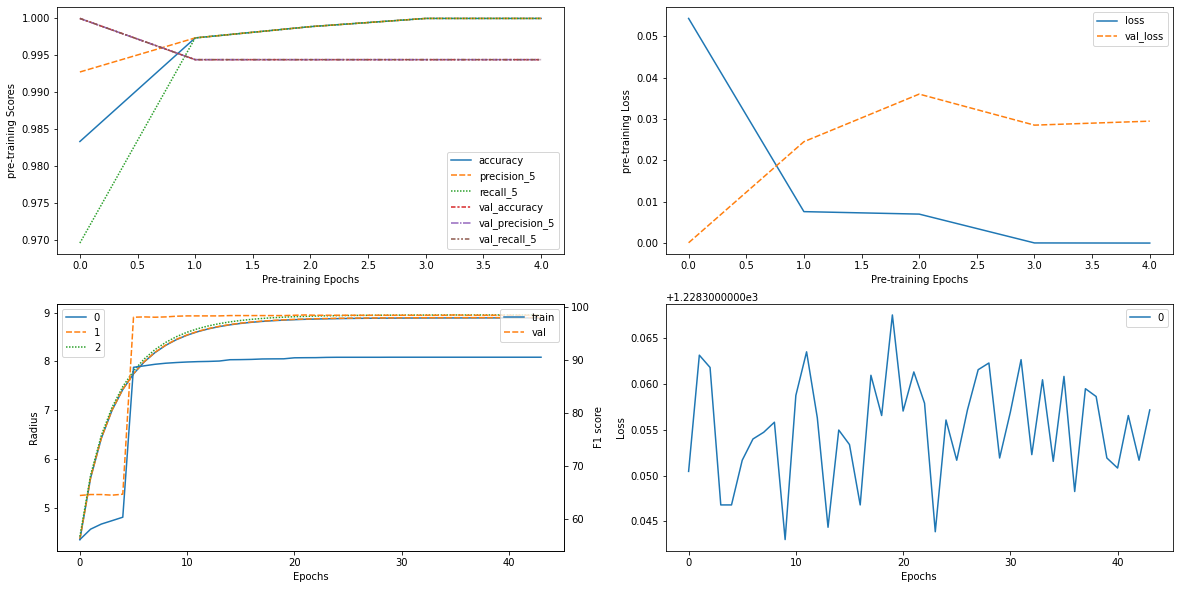

[[295   0   0   0]
 [  0 296   0   0]
 [  0   0 300   0]
 [  1   0   0 164]]
99.91
f1_weighted: 0.9990523922981531, f1_macro: 0.9988171097362155, f1_micro: 0.9990530303030303, f_measure: {'Known': 99.9436, 'Open': 99.696, 'F1-score': 99.8817}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       295
           1       1.00      1.00      1.00       296
           2       1.00      1.00      1.00       300
           5       1.00      0.99      1.00       165

    accuracy                           1.00      1056
   macro avg       1.00      1.00      1.00      1056
weighted avg       1.00      1.00      1.00      1056



In [8]:
comment="em size increase by 2 did very good, what happens if we increase further"
test_data, oset, hist = oset_train(ablation=3000,designated_ukc_cls=5,num_classes=3,embedding_size=16,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=5, wait_patience=8, comment=comment)